<a href="https://colab.research.google.com/github/Jia-wei-liao/NPDE_final_project/blob/main/DGM_Poisson2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Jia-Wei, Liao (jw.sc09@nycu.edu.tw)
# Final Project of Numerical Methods for Partial Differential Equations 2021

In [2]:
import random, time, csv, os
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

# Set up the Neural Network

In [3]:
class Residual_block(tf.keras.Model):
  def __init__(self, n_Neural):
    super(Residual_block, self).__init__()
    self.Dense1 = Dense(n_Neural)
    self.Dense2 = Dense(n_Neural)
  
  def call(self, inputs):
    x = self.Dense1(inputs)
    x = tf.math.sigmoid(x)*x
    x = self.Dense2(x)
    x = tf.math.sigmoid(x)*x + x

    return x


class ResNet(tf.keras.Model):
  def __init__(self):
    super(ResNet, self).__init__()
    self.RB1 = Residual_block(20)
    self.RB2 = Residual_block(20)
    self.RB3 = Residual_block(20)
    self.FinalLayer = Dense(1)

    self.input_layer = Input(shape=(2))
    self.outputs = self.call(self.input_layer)

    super(ResNet, self).__init__(inputs=self.input_layer, outputs=self.outputs)
    
  def call(self, inputs, training=True):
    x = self.RB1(inputs)
    x = self.RB2(x)
    x = self.RB3(x)
    x = self.FinalLayer(x)

    return x

Model: "res_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
residual_block (Residual_blo (None, 20)                480       
_________________________________________________________________
residual_block_1 (Residual_b (None, 20)                840       
_________________________________________________________________
residual_block_2 (Residual_b (None, 20)                840       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 21        
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________


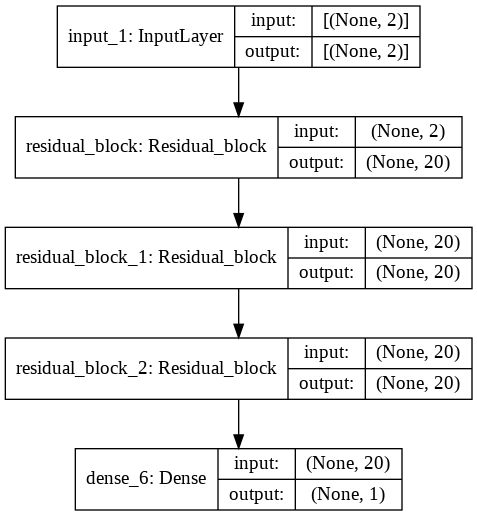

In [4]:
model = ResNet()
model.build((None, 2))
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

# Set the Parameter

In [5]:
epochs = 5000
Lambda = 1

lr = 5e-4
optimizer = Adam(lr)

mse = tf.keras.losses.MeanSquaredError()
N = 100  # number of interior sample point
M = 30  # number of boundary sample point

test_period = 500
save_period = 1000
save_weight = False
save_loss = False
weight_path = 'DGM_Poisson2DWeight'

if not os.path.isdir(weight_path):
  os.makedirs(weight_path)

# Define the function and exact solution

In [6]:
# def f(X):
#   x, y = X[:, 0], X[:, 1]
#   return 4+x*0+y*0


# def u_exact(X):
#   x, y = X[:, 0], X[:, 1]
#   return x**2+y**2


def f(X):
  x, y = X[:, 0], X[:, 1]
  return np.e**x*np.sin(np.pi*y)*(1-np.pi**2)


def u_exact(X):
  x, y = X[:, 0], X[:, 1]
  return np.e**x * np.sin(np.pi*y)

In [7]:
def generate_interior_point(num):
  sample = tf.random.uniform((num,2), minval=0, maxval=1, dtype=tf.dtypes.float32)
  return sample


def generate_boundary_point(num):
  left = np.random.rand(num,1)
  right = np.random.randint(0, 2, (num,1))
  random = np.concatenate([left, right], axis=1)
  change = np.random.choice(a=[True, False], size=(num))
  random[change, 0], random[change, 1] = random[change, 1], random[change, 0]
  random = tf.constant(random, dtype=tf.float32)
  return random


def BdyLoss(Xb, model, u_exact):
  U = model(Xb)
  u = u_exact(Xb)
  return mse(U, u)


def get_MeanLoss(List, keys):
  result = {}
  for key in keys:
    result[key] = np.mean([e[key] for e in List])
    
  return result


def save_csv(file_name, dict_list, key_list):
  with open(file_name, 'w', newline ='') as f:
    writer = csv.DictWriter(f, fieldnames = key_list)
    writer.writeheader()
    writer.writerows(dict_list)

# Training function

In [8]:
def Training(model, N, M, Loss_list, tic):
  with tf.GradientTape() as t3:
    with tf.GradientTape() as t2:
      with tf.GradientTape() as t1:
        X, Xb = generate_interior_point(N), generate_boundary_point(M)
        t1.watch(X)
        t2.watch(X)
        U = model(X)

      # Gradient
      DU = t1.gradient(U, X)

    # Laplacian
    DDU = t2.gradient(DU, X)
    LU = tf.reduce_sum(DDU, 1)
    F = f(X)

    Li, Lb = mse(LU, F)/N, BdyLoss(Xb, model, u_exact)/M
    loss = Li + Lb*Lambda
    Loss_list.append({'InteriorLoss': Li.numpy(), 'BoundaryLoss': Lb.numpy(), 'TotalLoss': loss.numpy()})

  grads = t3.gradient(loss, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  if ep%100==1:
    print(f'Epoch: {ep}, Time: {time.time()-tic:.0f}, '\
    f'InteriorLoss: {Li:.8f}, BoundaryLoss: {Lb:.8f}, '\
    f'TotalLoss: {float(loss):.8f}')

# Testing function

In [9]:
def PlotMesh(x, y, u, title):
  u = u[:-1, :-1]
  levels = MaxNLocator(nbins=15).tick_values(u.min(), u.max())
  cmap = plt.get_cmap('YlGnBu')
  im = plt.pcolormesh(x, y, u, cmap=cmap)
  plt.colorbar(im)
  plt.title(title)


def PointwiseError(U, u, method):
  if method == 'abs':
    return abs(U-u)
  
  if method == 'relative':
    return abs(U-u)/abs(u+1e-8)


def compute_error(U, u, method):
  abs_error = abs(U-u)

  if method == 'InfNorm':
    return np.max(abs_error)

  if method == 'TwoNorm':
    return np.sqrt(np.mean(abs_error**2))

  if method == 'Relative':
    return np.sqrt(np.mean(abs_error**2))/np.sqrt(np.mean(u**2))


def Testing(x, y, model):
  [xx, yy] = np.meshgrid(x, y)
  xx = xx.reshape(-1,1)
  yy = yy.reshape(-1,1)
  X = np.hstack([xx,yy])

  U = np.array(model(X)).reshape(100,100)
  u = u_exact(X).reshape(100,100)
  abs_error = PointwiseError(U, u, 'abs')
  relative_error = PointwiseError(U, u, 'relative')

  plt.figure(figsize=(10,8))
  plt.subplot(2,2,1)
  PlotMesh(x, y, U, 'DNN')
  plt.subplot(2,2,2)
  PlotMesh(x, y, u, 'exact')
  plt.subplot(2,2,3)
  PlotMesh(x[1:99], y[1:99], abs_error[1:99, 1:99], 'error')
  plt.subplot(2,2,4)
  PlotMesh(x[1:99], y[1:99], relative_error[1:99, 1:99], 'relative error')
  plt.show()
  
  Inf = compute_error(U, u, 'InfNorm')
  Two = compute_error(U, u, 'TwoNorm')
  Relative = compute_error(U, u, 'Relative')
  print(f'InfNorm: {Inf:.8f}, TwoNorm: {Two:.8f}, Relative: {Relative:.8f}')


x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)

# Training and Testing process

Epoch: 1, Time: 0, InteriorLoss: 1.29731929, BoundaryLoss: 0.02421769, TotalLoss: 1.32153702
Epoch: 101, Time: 6, InteriorLoss: 0.24464306, BoundaryLoss: 0.02099844, TotalLoss: 0.26564151
Epoch: 201, Time: 12, InteriorLoss: 0.01077840, BoundaryLoss: 0.00237078, TotalLoss: 0.01314918
Epoch: 301, Time: 18, InteriorLoss: 0.00240748, BoundaryLoss: 0.00141027, TotalLoss: 0.00381774
Epoch: 401, Time: 24, InteriorLoss: 0.00111163, BoundaryLoss: 0.00178729, TotalLoss: 0.00289892


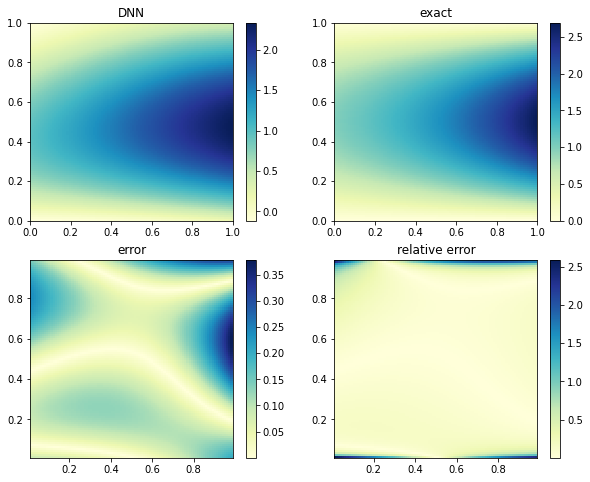

InfNorm: 0.40912317, TwoNorm: 0.12166439, Relative: 0.09659876
Epoch: 501, Time: 31, InteriorLoss: 0.00143741, BoundaryLoss: 0.00103292, TotalLoss: 0.00247033
Epoch: 601, Time: 37, InteriorLoss: 0.00126573, BoundaryLoss: 0.00071816, TotalLoss: 0.00198389
Epoch: 701, Time: 42, InteriorLoss: 0.00119249, BoundaryLoss: 0.00117054, TotalLoss: 0.00236303
Epoch: 801, Time: 48, InteriorLoss: 0.00084847, BoundaryLoss: 0.00087033, TotalLoss: 0.00171880
Epoch: 901, Time: 54, InteriorLoss: 0.00076015, BoundaryLoss: 0.00116410, TotalLoss: 0.00192426


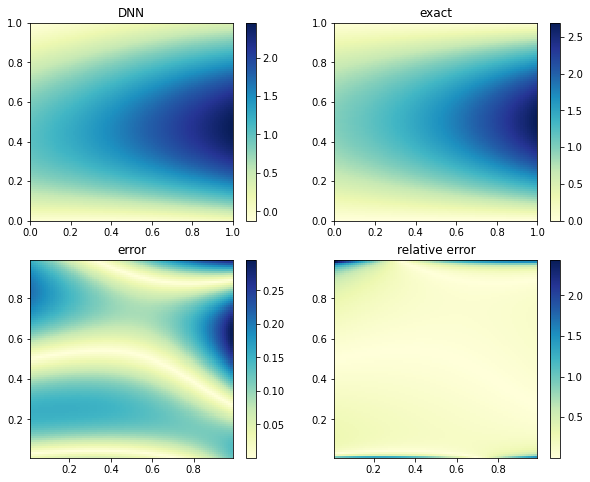

InfNorm: 0.32538345, TwoNorm: 0.11195032, Relative: 0.08888601
Epoch: 1001, Time: 61, InteriorLoss: 0.00049958, BoundaryLoss: 0.00076253, TotalLoss: 0.00126210
Epoch: 1101, Time: 67, InteriorLoss: 0.00043679, BoundaryLoss: 0.00091145, TotalLoss: 0.00134824
Epoch: 1201, Time: 72, InteriorLoss: 0.00037103, BoundaryLoss: 0.00064469, TotalLoss: 0.00101572
Epoch: 1301, Time: 78, InteriorLoss: 0.00033429, BoundaryLoss: 0.00075416, TotalLoss: 0.00108845
Epoch: 1401, Time: 84, InteriorLoss: 0.00044336, BoundaryLoss: 0.00057130, TotalLoss: 0.00101466


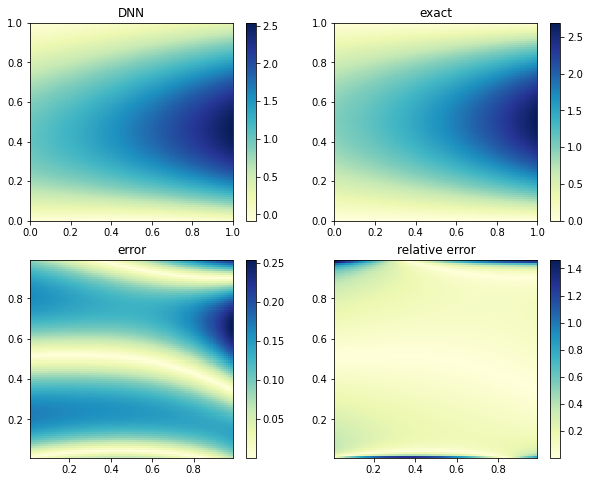

InfNorm: 0.27887779, TwoNorm: 0.11251008, Relative: 0.08933045
Epoch: 1501, Time: 91, InteriorLoss: 0.00030202, BoundaryLoss: 0.00066964, TotalLoss: 0.00097166
Epoch: 1601, Time: 97, InteriorLoss: 0.00028632, BoundaryLoss: 0.00052292, TotalLoss: 0.00080924
Epoch: 1701, Time: 103, InteriorLoss: 0.00029419, BoundaryLoss: 0.00040741, TotalLoss: 0.00070161
Epoch: 1801, Time: 108, InteriorLoss: 0.00020597, BoundaryLoss: 0.00029754, TotalLoss: 0.00050351
Epoch: 1901, Time: 114, InteriorLoss: 0.00017788, BoundaryLoss: 0.00063855, TotalLoss: 0.00081643


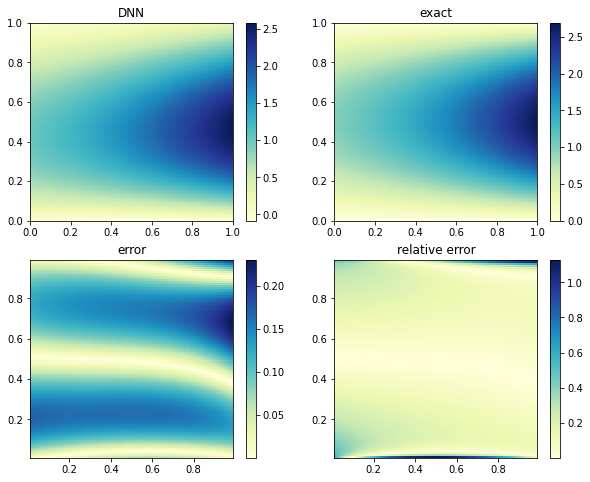

InfNorm: 0.25035000, TwoNorm: 0.11349500, Relative: 0.09011245
Epoch: 2001, Time: 121, InteriorLoss: 0.00027256, BoundaryLoss: 0.00030476, TotalLoss: 0.00057732
Epoch: 2101, Time: 127, InteriorLoss: 0.00013576, BoundaryLoss: 0.00033497, TotalLoss: 0.00047073
Epoch: 2201, Time: 133, InteriorLoss: 0.00007811, BoundaryLoss: 0.00034939, TotalLoss: 0.00042749
Epoch: 2301, Time: 139, InteriorLoss: 0.00009746, BoundaryLoss: 0.00035817, TotalLoss: 0.00045564
Epoch: 2401, Time: 144, InteriorLoss: 0.00007290, BoundaryLoss: 0.00042289, TotalLoss: 0.00049579


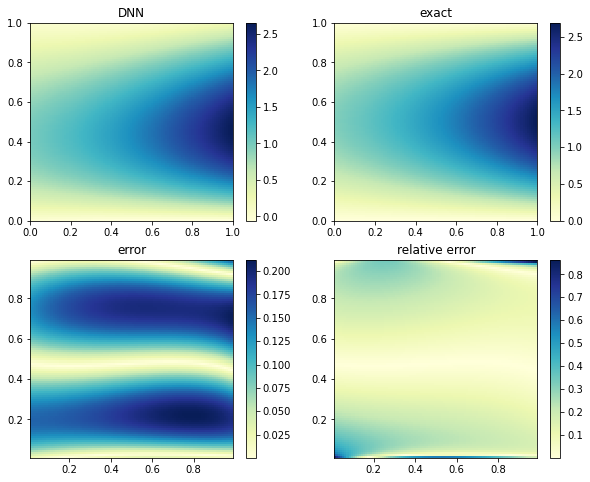

InfNorm: 0.21494526, TwoNorm: 0.13076022, Relative: 0.10382065
Epoch: 2501, Time: 151, InteriorLoss: 0.00007378, BoundaryLoss: 0.00030060, TotalLoss: 0.00037438
Epoch: 2601, Time: 157, InteriorLoss: 0.00006777, BoundaryLoss: 0.00033208, TotalLoss: 0.00039985
Epoch: 2701, Time: 163, InteriorLoss: 0.00008253, BoundaryLoss: 0.00027008, TotalLoss: 0.00035261
Epoch: 2801, Time: 168, InteriorLoss: 0.00005729, BoundaryLoss: 0.00036484, TotalLoss: 0.00042213
Epoch: 2901, Time: 174, InteriorLoss: 0.00007887, BoundaryLoss: 0.00030591, TotalLoss: 0.00038477


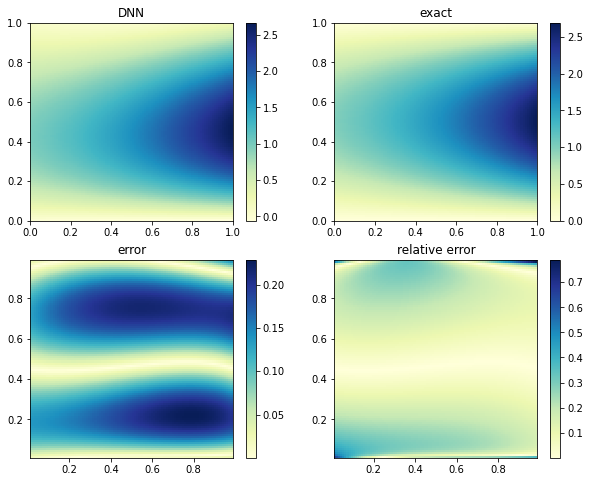

InfNorm: 0.22825181, TwoNorm: 0.13744363, Relative: 0.10912712
Epoch: 3001, Time: 181, InteriorLoss: 0.00007800, BoundaryLoss: 0.00022127, TotalLoss: 0.00029926
Epoch: 3101, Time: 187, InteriorLoss: 0.00005599, BoundaryLoss: 0.00030723, TotalLoss: 0.00036322
Epoch: 3201, Time: 193, InteriorLoss: 0.00006708, BoundaryLoss: 0.00022442, TotalLoss: 0.00029150
Epoch: 3301, Time: 198, InteriorLoss: 0.00002680, BoundaryLoss: 0.00024684, TotalLoss: 0.00027363
Epoch: 3401, Time: 204, InteriorLoss: 0.00009578, BoundaryLoss: 0.00038020, TotalLoss: 0.00047598


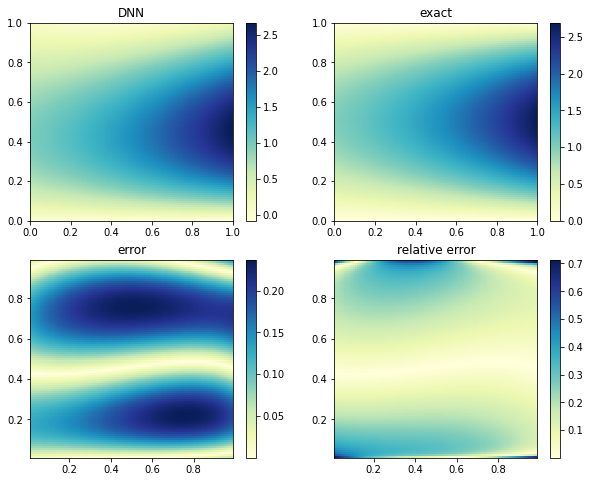

InfNorm: 0.23638585, TwoNorm: 0.14462317, Relative: 0.11482751
Epoch: 3501, Time: 211, InteriorLoss: 0.00005596, BoundaryLoss: 0.00024734, TotalLoss: 0.00030330
Epoch: 3601, Time: 217, InteriorLoss: 0.00007021, BoundaryLoss: 0.00036501, TotalLoss: 0.00043522
Epoch: 3701, Time: 223, InteriorLoss: 0.00004775, BoundaryLoss: 0.00027041, TotalLoss: 0.00031816
Epoch: 3801, Time: 228, InteriorLoss: 0.00004059, BoundaryLoss: 0.00039907, TotalLoss: 0.00043966
Epoch: 3901, Time: 234, InteriorLoss: 0.00007739, BoundaryLoss: 0.00040532, TotalLoss: 0.00048272


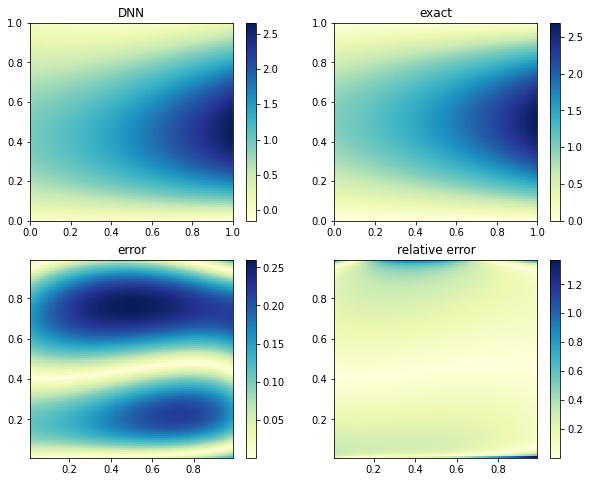

InfNorm: 0.25943832, TwoNorm: 0.14881642, Relative: 0.11815686
Epoch: 4001, Time: 241, InteriorLoss: 0.00003244, BoundaryLoss: 0.00020001, TotalLoss: 0.00023245
Epoch: 4101, Time: 247, InteriorLoss: 0.00004707, BoundaryLoss: 0.00023420, TotalLoss: 0.00028128
Epoch: 4201, Time: 253, InteriorLoss: 0.00003180, BoundaryLoss: 0.00011226, TotalLoss: 0.00014406
Epoch: 4301, Time: 259, InteriorLoss: 0.00004410, BoundaryLoss: 0.00037474, TotalLoss: 0.00041884
Epoch: 4401, Time: 265, InteriorLoss: 0.00005497, BoundaryLoss: 0.00023438, TotalLoss: 0.00028935


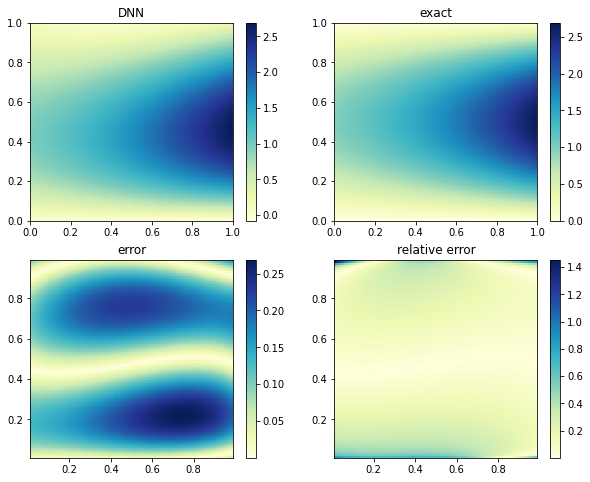

InfNorm: 0.26837907, TwoNorm: 0.14762873, Relative: 0.11721386
Epoch: 4501, Time: 272, InteriorLoss: 0.00006117, BoundaryLoss: 0.00021154, TotalLoss: 0.00027270
Epoch: 4601, Time: 278, InteriorLoss: 0.00003490, BoundaryLoss: 0.00037917, TotalLoss: 0.00041407
Epoch: 4701, Time: 283, InteriorLoss: 0.00007839, BoundaryLoss: 0.00018075, TotalLoss: 0.00025914
Epoch: 4801, Time: 289, InteriorLoss: 0.00003911, BoundaryLoss: 0.00022450, TotalLoss: 0.00026361
Epoch: 4901, Time: 295, InteriorLoss: 0.00004994, BoundaryLoss: 0.00011233, TotalLoss: 0.00016227


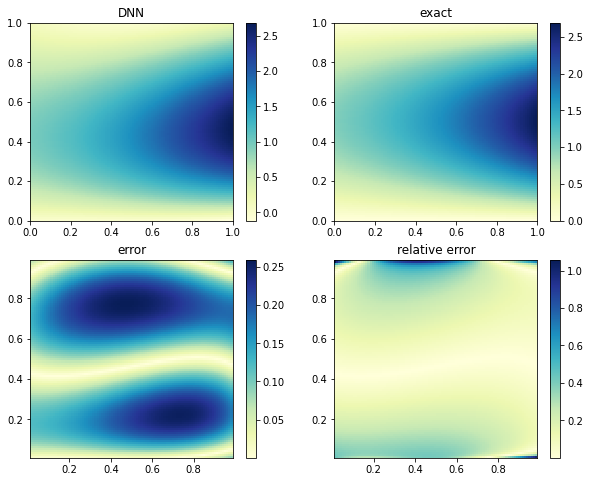

InfNorm: 0.25889058, TwoNorm: 0.15208761, Relative: 0.12075411


In [10]:
Loss_list = []
tic = time.time()
for ep in range(1, epochs+1):
  Training(model, N, M, Loss_list, tic)
  if ep % test_period ==0:
    Testing(x, y, model)
  
  # Save weight
  if save_weight and (ep==1 or ep % save_period ==0):
    filename = f'DGM_Poisson2DWeight_{ep}_{N}_{M}_{lr:.0e}'
    save_path = os.path.join(weight_path, filename + '.h5')
    model.save_weights(save_path)

# Save information

In [11]:
if save_loss:
  filename = f'DGM_Poisson2DWeight_{epochs}_{N}_{M}_{lr:.0e}'
  save_csv(filename+'.csv', Loss_list, ['InteriorLoss', 'BoundaryLoss', 'TotalLoss'])